In [ ]:
from scipy import optimize, spatial
import numpy as np
import pandas as pd
from numpy import sin, cos, exp
import operator

import seaborn as sns
import bokeh
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import plotly
import plotly.plotly as py
import plotly.graph_objs as go

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

%matplotlib notebook
%matplotlib inline



__Function:__ $ f(x, y) = sin(x)e^{(1-cos(y))^2}+cos(y)e^{(1-sin(x))^2}+(x-y)^2 $  
__Domain:__ $ (x + 5)^2  + (y + 5)^2 < 25$

In [ ]:
def f_mishras_bird(x):
    
    return sin(x[1])*exp( (1 - cos(x[0]))**2 ) + cos(x[0])*exp( (1 - sin(x[1]))**2 ) + (x[0] - x[1])**2

def domain(x):
    
    return (x[0] + 5)**2 + (x[1] + 5)**2 - 25

In [ ]:
x_bounds = [-10,0]
y_bounds= [-10,0]
n = 1000

x = np.linspace(*x_bounds, n)
y = np.linspace(*y_bounds, n)

xx, yy = np.meshgrid(x,y)
grid = np.concatenate((np.expand_dims(xx, axis = 2),np.expand_dims(yy, axis = 2)), axis = 2)
f_matrix = np.apply_along_axis(f_mishras_bird, 2, grid)

In [4]:
layout = go.Layout(
        title='Mishras Bird Evaluation',
        autosize=False,
        width=500,
        height=500,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    
    fig = go.Figure(data=[go.Surface(z = f_matrix, x = x, y = y)], layout=layout)
    
    return fig, f_matrix

py.iplot(fig, filename='elevations-3d-surface')


High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~blufzzz/0 or inside your plot.ly account where it is named 'elevations-3d-surface'


As we can see Mishra-s bird has a lot of local minimas: depending on the initial simplex the Nelder-Mead method will converge to the different local minima.

### Animaton

In [4]:
def update_NelderMead(frame):
    
    x = opt.simplexes[frame]

    ax.plot([x[0][0], x[1][0]],[x[0][1],x[1][1]],'r')
    ax.plot([x[0][0], x[2][0]],[x[0][1],x[2][1]],'r')
    ax.plot([x[1][0], x[2][0]],[x[1][1],x[2][1]],'r')

def update_CoordDesc(frame):
    
    if frame > 1:
        x = opt.x_s[frame-2:frame]
        ax.plot([x[0][0], x[1][0]],[x[0][1],x[1][1]],'r')
    
plt.rcParams["animation.html"] = "html5"
plt.rcParams['animation.ffmpeg_path'] =  'C:\\ffmpeg\\bin\\ffmpeg.exe'   

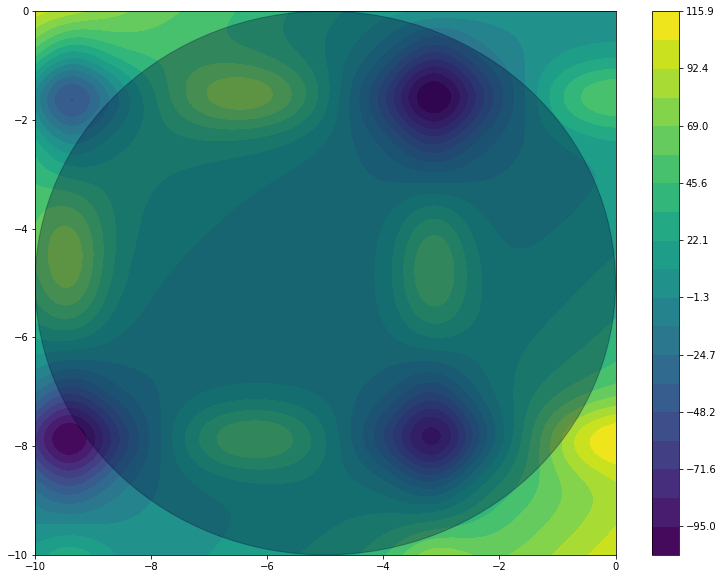

In [17]:
x_bounds = [-10,0]
y_bounds= [-10,0]
dx = dy = 1
n = 1000

x = np.linspace(*x_bounds, n)
y = np.linspace(*y_bounds, n)

fig_map, ax = plt.subplots(figsize= (13,10))

cm = ax.contourf(x,y,f_matrix, np.linspace(f_matrix.min(), f_matrix.max(), 20), cmap = 'viridis')
plt.colorbar(cm, ax = ax)
ax.add_artist(plt.Circle((-5, -5), 5, color='#000033', alpha=0.3))

plt.show()

## Nelder-Mead

In [6]:
class NelderMeadOptimizer:
    
    '''
    Class for Nelder-Mead optimization process
    alpha - reflection coeff
    beta - shrinkage coeff
    gamma - extention coeff1
    '''
    
    def __init__(self, alpha = 1.0, beta = 0.5, gamma = 2.0):
        
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.oracle_calls = 0
        self.symplex_pairwise_sum = []
        self.f_ls = []
        self.simplexes = []
        self.iterations = 0
        
        
    def callback_default(self):
        
        pass
    
    def extract_simplex(self,f_x):
        
        # sorting by index
        f_x_sorted = sorted(f_x, key = lambda x: x[0])
        simplex = np.array([x for i,x,f in f_x_sorted])
        
        return simplex
     
    def check_domain(self, x):
        
        op_type = self.domain['type']
        func = self.domain['func']
        value = self.domain['value']
        ops = { "=": operator.eq,
               "<": operator.lt,
              '>' : operator.gt}
        
        return ops[op_type](func(x),value)
        
    def align(self, x, x_from_domain, max_iter = 1000):
        
        '''
        we'll simple move x to x_from_domain
        '''
        
        i = 0
        while not self.check_domain(x) or i >= max_iter:
            
            x = x + (x_from_domain - x)/2.
            i += 1
            
        return x    

    def get_pairw_dist(self, f_x):

        simplex = np.array([x for i,x,f in f_x])

        pairwise_sum = spatial.distance.pdist(simplex).sum()
        
        self.symplex_pairwise_sum.append(pairwise_sum)
        
        return pairwise_sum
    
    def get_init_simplex(self):
        
        scale_factor = 5./4

        coords = np.random.normal(loc = [-5,-5], scale = scale_factor, size = (self.n+1, self.n))

        return coords

    def minimize(self, func, domain = None, x0 = None, n = None, 
                 callback = callback_default, max_iter = 1000,
                 tol = 1e-7, freq = 100, verbose = True):
        
        
        '''
        domain = {'func': f, 'type': '='}
        '''
        
        assert(x0 or n)
        
        self.n = n if n else len(x0)
        self.domain = domain
        
        if x0 == None:
            x0 = self.get_init_simplex()
        
        x = x0
            
        # init    
        f_x = [ [i, x_i, func(x_i)] for i,x_i in enumerate(x) ]    
        self.oracle_calls += len(x)

        while self.get_pairw_dist(f_x) > tol:
            
            self.iterations+=1
            self.simplexes += [self.extract_simplex(f_x)]
            
            if self.iterations > max_iter:
                break
                
            # sort by func value
            f_x = sorted(f_x, key = lambda x: x[2] ,reverse=True)

            x_h = f_x[0][1]
            x_g = f_x[1][1]
            x_l = f_x[-1][1]
            
            f_h = f_x[0][2]
            f_g = f_x[1][2]
            f_l = f_x[-1][2]
            self.f_ls.append(f_l)
            
            # mass center
            x_c = np.mean([ x for i,x,f in f_x[1:] ], axis = 0 )
            
            # reflection
            x_r = x_c + self.alpha*(x_c - x_h)
            
            if not self.check_domain(x_r):
                x_r = self.align(x_r, x_c)
                
            f_r = func(x_r)
            self.oracle_calls += 1
            
            # ideal
            if f_r <= f_l:
                # extention
                x_e = x_c + self.gamma*(x_r - x_c)
                if not self.check_domain(x_e):
                    x_e = self.align(x_e, x_l)
                f_e = func(x_e)
                self.oracle_calls += 1
                
                # change x_h
                f_x[0][1:] = [x_e, f_e] if f_e < f_r else [x_r, f_r]
                continue
                
            # not-ideal
            elif f_l < f_r < f_g:
                # change x_h
                f_x[0][1:] = [x_r, f_r]
                continue
            
            # not-bad
            else:
                if f_g <= f_r < f_h:
                    # contraction from x_r to x_c
                    x_s = x_c + self.beta*(x_r - x_c)
                    f_s = func(x_s)
                    self.oracle_calls += 1
                    
                    if f_s < f_r:
                        f_x[0][1:] = [x_s, f_s]
                        continue
                
                else:
                    # contraction from x_h to x_c
                    x_s = x_c + self.beta*(x_h - x_c)
                    f_s = func(x_s)
                    self.oracle_calls += 1
                
                    if f_s <= f_h:
                        f_x[0][1:] = [x_s, f_s]
                        continue
   
                # shrinkage
                for i,x,f in f_x:
                    x_i = x + (x - x_l)/2.
                    f_x[i][1:] = [x_i, func(x_i)]
                    self.oracle_calls += 1
        
        print ('Number of oracle calls: ', self.oracle_calls) 
        print ('Iterations: ', self.iterations) 
        print('Min F achieved', f_l)

        return self.extract_simplex(f_x)
    

In [15]:
opt = NelderMeadOptimizer()

x = opt.minimize(f_mishras_bird,
                 domain={'func':domain, 'type': '<', 'value':0},
                 tol = 1e-9,
                 n = 2)

Iterations so far:  100
Number of oracle calls:  488
Iterations:  171
Min F achieved -87.3108827330036


In [91]:
animation.FuncAnimation(fig, update_NelderMead, frames=range(opt.iterations), interval=200)

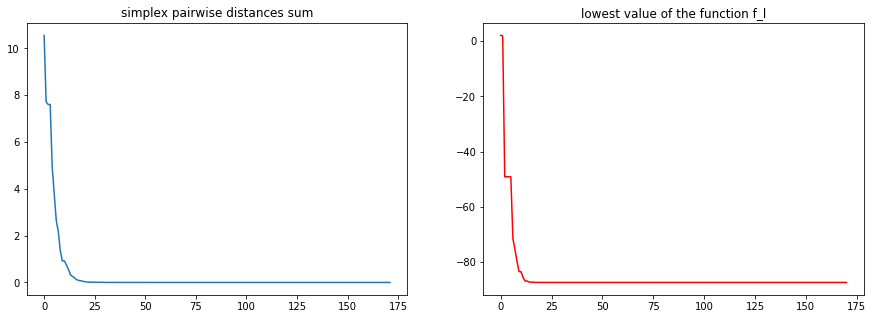

In [16]:
_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (15,5))

ax1.plot(opt.symplex_pairwise_sum)
ax1.set_title('simplex pairwise distances sum')
ax2.plot(opt.f_ls,'r')
ax2.set_title('lowest value of the function f_l')
plt.show()

## Coordinate descent

In [11]:
class CoordDescentOptimizer:
    
    def __init__(self):
        
        self.f_vals = []
        self.x_s = []
        self.oracle_calls = 0
        self.iterations = 0
        
    def get_init_x0(self):
        
        scale_factor = 5./4

        return np.random.normal(loc = [-5,-5], scale = scale_factor, size = (self.n))
    
    def stopping_criteria(self):
        
        if len(self.f_vals) > 10:
            return np.var(self.f_vals[:-10]) > self.tol or np.var(self.x_s[:-10]) > self.tol
        
        else:
            return True
    
    def minimize(self, func, domain = None, x0 = None,
                 n = 2, tol = 1e-10, max_iter = 1000,
                 gamma_0 = 1e-1, alpha_0 = 2e-1, verbose = True, freq = 100):
        
        assert(x0 or n)
        
        self.n = n if n else len(x0) 
        self.tol = tol
        self.gamma_0 = gamma_0
        self.alpha_0 = alpha_0
        
        if x0 == None:
            x0 = self.get_init_x0()
            
        gamma_k = gamma_0
        alpha_k = alpha_0
        x = x0
        
        while self.stopping_criteria():
            
            if self.iterations >= max_iter:
                break
            
            i = self.iterations%self.n    
            self.iterations += 1
            
            f_x = func(x)
            self.x_s.append(x)
            self.f_vals.append(f_x)
            
            e_i = np.zeros((self.n))
            e_i[i] = 1
            s_k = (func( x + alpha_k*e_i ) - f_x)*e_i
            x = x - gamma_k*s_k
            
            self.oracle_calls += 2
            
        print ('Number of oracle calls: ', self.oracle_calls) 
        print ('Iterations: ', self.iterations) 
        print('Min F achieved', f_x)
            
        return x

In [16]:
opt = CoordDescentOptimizer()

x = opt.minimize(f_mishras_bird, n = 2)

Number of oracle calls:  2000
Iterations:  1000
Min F achieved 1.5278665759234908


### Optimization

In [15]:
animation.FuncAnimation(fig_map, update_CoordDesc, frames=range(opt.iterations), interval=120)

In [ ]:
plt.plot(opt.f_vals)
plt.title('f')
plt.xlabel('iteration')